In [2]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import matplotlib.pyplot as plt

from diffusion_map import DIFFUSION_MAP, ROSELAND

In [3]:
IMG_SIZE = 32
#定義img_transform
img_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(), # Scales data into [0,1]
    transforms.Lambda(lambda x: x),
    transforms.Lambda(lambda t: (t * 2) - 1), # Scale between [-1, 1]
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
    ])

reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

In [4]:
def imscatter(x, y, ax, imageData, zoom, c:str, label:str):
    images = []
    for i in range(len(x)):
        x0, y0 = x[i], y[i]
        # Convert to image
        img = reverse_transforms(imageData[i])
        # Note: OpenCV uses BGR and plt uses RGB
        image = OffsetImage(img, zoom=zoom, alpha=1)
        ab = AnnotationBbox(image, (x0, y0), xycoords='data', pad=.15, bboxprops={"color": c, "alpha": .5}, label=label)#, frameon=False)
        images.append(ax.add_artist(ab))
    
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()

In [5]:
# for roseland, generate landmark set

def gen_land(data, beta: float = .5):
    '''
    This function is to generate a landmark set from data.\\
    The size of landmark set is n^beta, where n is the number of data.
    beta: 0 ~ 1, float.

    return landmark set
    '''
    n = len(data)
    m = int(pow(n, beta))
    subi = range(int(n / m) - 1, n, int(n / m))
    land = data[subi, :].cpu()
    return land

### Data Loading

In [6]:
# data loading
data = torchvision.datasets.MNIST(
    root='./mnist',
    train=False,
    transform = img_transform,
    download=True
)
datay = np.array([data[i][1] for i in range(10000)])
data = torch.concat([torch.unsqueeze(data[i][0], dim=0) for i in range(10000)]).detach().cpu()
NumOfClass = 10 # MNIST has 10 classes

### Apply Diffusion Maps or Roseland

In [7]:
# dm = DIFFUSION_MAP(sigma=7, c = 3, opt = 'local')
# dm.train(data)

land = gen_land(data=data, beta=.5)
rl = ROSELAND(sigma=7, c = 3, opt = 'local')
rl.train(data, land)

### Visualization

In [8]:
# construct the colormap

colormap = "viridis"
cmap = matplotlib.colormaps.get_cmap(colormap)
ColorList = [cmap(i/(NumOfClass - 1)) for i in range(NumOfClass)]

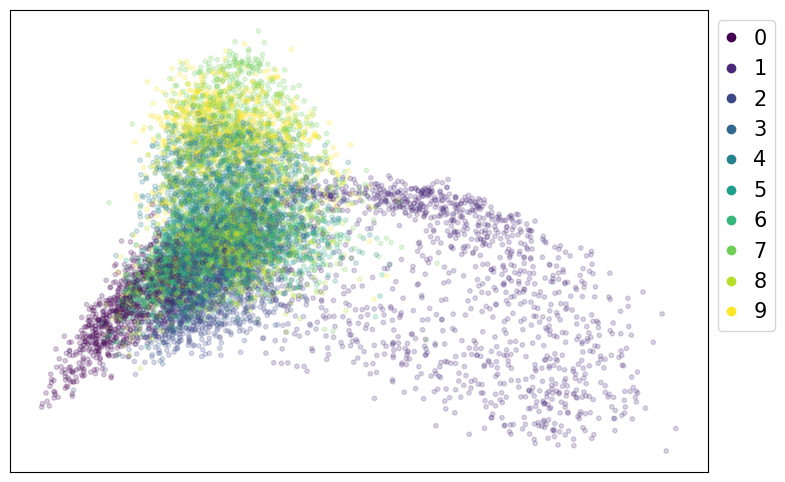

In [9]:
# visualize in 2D, show position by points

plt.figure(figsize=(9, 6))
scatter = plt.scatter(*rl.Y[:, :2].T, c=datay, s=10, alpha= 0.2, cmap=colormap)

leg = plt.legend(handles=scatter.legend_elements(num=None)[0], labels=list(range(NumOfClass)), fontsize=15, handlelength=0.5, loc="upper left", bbox_to_anchor=(1, 1))
for lh in leg.legend_handles: 
    lh.set_alpha(1)

plt.xticks([])
plt.yticks([])
plt.show()

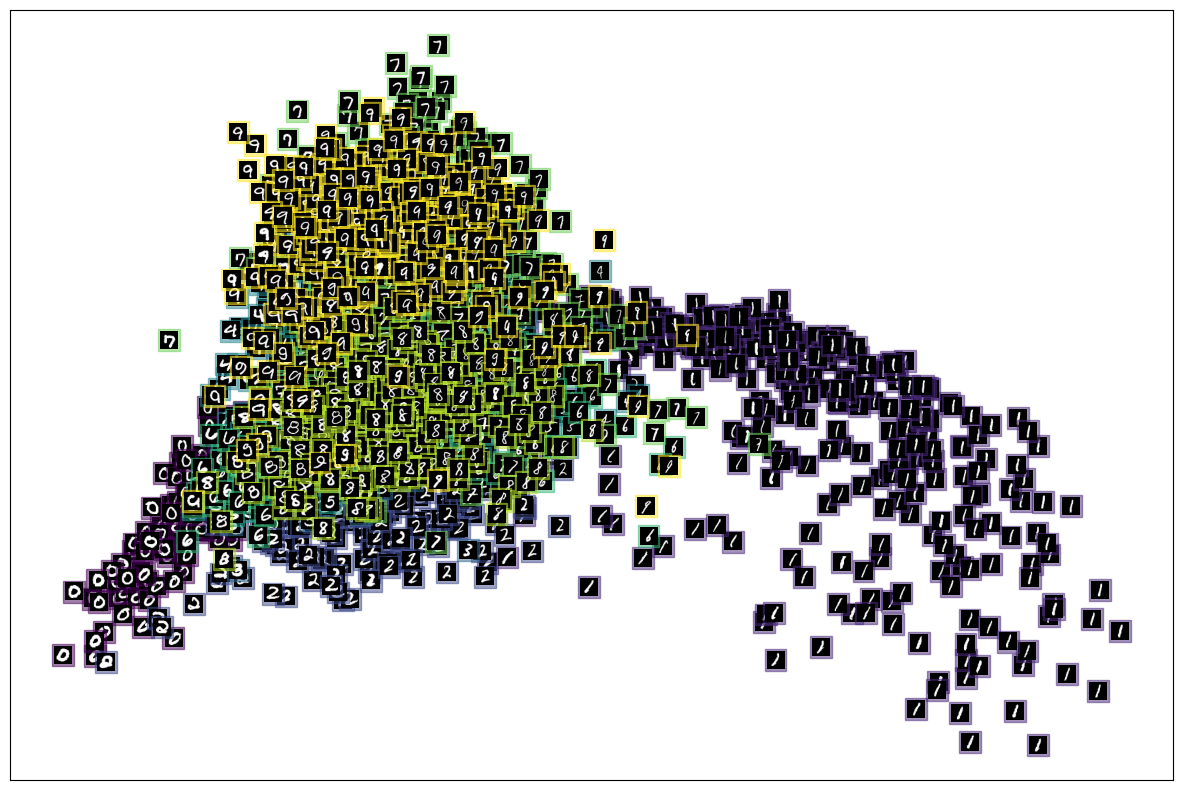

In [10]:
# visualize in 2D, show position with data exactly image

fig, ax = plt.subplots(figsize=(15, 10))
for i in range(10):
    subsamples = np.where(datay == i)[0] # totally index of class i
    subsamples = subsamples[:int(len(subsamples) * 0.3)] # choose 30% samples to draw
    imscatter(rl.Y[:, 0][subsamples], rl.Y[:, 1][subsamples], ax, data[subsamples], 0.4, c=ColorList[i], label=i)
    plt.xticks([])
    plt.yticks([])